In [9]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc
import scipy
warnings.filterwarnings('ignore')
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV


def check_read_inside_region(start, seq, region):
        read_end = start + len(seq)
        region_start = int(region.split(":")[1].split("-")[0])
        region_end = int(region.split(":")[1].split("-")[1])
        if start >= region_start and read_end <= region_end:
            return "in"
        else: 
            return "overlap"

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/GSHD_HN01/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

mode = "all"
input_cancer_class = "PAN_CANCER"
selected_candi_features = "ratio_raw"

path_to_main_output = os.path.join(outdir, PROJECT, output_version)
path_to_02_output = os.path.join(path_to_main_output, "PANCANCER02_output")
path_to_04_output = os.path.join(path_to_main_output, "PANCANCER04_output")
path_to_06_output = os.path.join(path_to_main_output, "PANCANCER06_output")
path_to_07_output = os.path.join(path_to_main_output, "PANCANCER07_output")
path_to_08_output = os.path.join(path_to_main_output, "PANCANCER08_output")

path_to_tf_output = os.path.join(outdir, PROJECT, output_version, "TF_output")
path_to_03_tf_output = os.path.join(path_to_tf_output, "03_output")
path_to_save_models = os.path.join(path_to_03_tf_output, "models")
path_to_savefile = os.path.join(path_to_03_tf_output, "savefile")

os.system(f"mkdir -p {path_to_save_models}")
os.system(f"mkdir -p {path_to_savefile}")

candidf = pd.read_excel(os.path.join(path_to_08_output, "candi_reads_all_{}_vs_control.xlsx".format("PAN_CANCER")))
candidf_origin = candidf.copy()
convert_ratio = {
    '0001': 0.001, 
    '001': 0.01, 
    '0005': 0.005, 
    '005': 0.05, 
    '01': 0.1,
    '05': 0.5,
    '08': 0.8
}

metadata = pd.read_csv("metadata_Spike_in_silico_TMD_samples_from_tissue_highdepth_07102024.csv")


print(f"Number of samples in this version: {candidf.shape[0]}")
ichorcnadf = pd.read_csv("validation_Truong_Vi/metadata_Spike_in_silico_GW_samples_from_tissue_highdepth_15112024.csv")

candidf = candidf.merge(ichorcnadf[["SampleID", "ichorCNA"]], right_on = "SampleID", left_on = "SampleID")
candidf["spike_in_ratio"] = candidf["SampleID"].apply(lambda x: convert_ratio[x.split("_")[4]])
candidf["Label"] = candidf[["SampleID", "spike_in_ratio"]].apply(lambda x: x[0].split("_")[8] if x[1] != 0.8 else x[0].split("_")[9], axis = 1)

print(f"Number of samples in this version: {candidf.shape[0]}")

# metadata = pd.concat([metadata_spike_in, new_metadata], axis = 0)
candidf = candidf.merge(metadata[["SampleID", "Spike_in_label"]], right_on = "SampleID", left_on = "SampleID")
maindf = candidf.copy()

maindf["Label"] = maindf["Label"].apply(lambda x: "Control" if x == "Control" else input_cancer_class)
maindf['Label'] = pd.Categorical(maindf['Label'], categories=[input_cancer_class, "Control"])

maindf = maindf[~maindf["ichorCNA"].isna()][["SampleID", "ratio_in_reads", "ratio_raw", "ichorCNA", "spike_in_ratio", "Spike_in_label"]]
maindf.columns = ["SampleID", "ratio_in_reads", "ratio_raw", "ichorCNA", "spike_in_ratio", "spike_in_label"]
maindf["spike_in_label"] = "PAN_CANCER"

Number of samples in this version: 4956
Number of samples in this version: 4956


In [10]:
##### LOD data
tmp_loddf = pd.read_csv("./ichorCNA/analytical_LOD_TF.csv")
tmp_loddf['Label'] = tmp_loddf["LABEL"].apply(lambda x: "CRC" if x == "Colorectal cancer" else x.split(" ")[0])
tmp_loddf["SampleID"] = tmp_loddf["Sample"].values
tf_candi_sampledf = pd.read_excel(os.path.join(path_to_04_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))
tf_candi_sampledf = tf_candi_sampledf[['SampleID', 'ratio_raw', 'ratio_in_reads']]

tmp_loddf = tmp_loddf[["Sample", "Actual tumor_fraction_ichorCNA", "Simulated TF", "spike-in"]]
tmp_loddf.columns = ["SampleID", "ichorCNA", "Simulated TF", "spike_in"]

loddf = tmp_loddf.merge(tf_candi_sampledf, right_on = "SampleID", left_on = "SampleID")
loddf["spike_in_label"] = loddf["Simulated TF"].apply(lambda x: "Control" if x == "Healthy-control" else input_cancer_class)
convert_ratio = {
    '50' : 0.5, 
    '100': 1, 
    '0.5': 0.005, 
    '25': 0.25, 
    '15': 0.15, 
    '5': 0.05, 
    '1': 0.01, 
    'HC': 0
}

loddf["spike_in_ratio"] = loddf["spike_in"].apply(lambda x: convert_ratio[x])
loddf = loddf[["SampleID", "ratio_in_reads", "ratio_raw", "ichorCNA", "spike_in_ratio", "spike_in_label"]]
loddf = loddf[loddf["SampleID"].duplicated() == False]
loddf_cancer = loddf[loddf["spike_in_ratio"] != 0].copy()
loddf_control = loddf[loddf["spike_in_ratio"] == 0].copy()

##### NEW VALIDATION DATA
validationdf = pd.read_excel(os.path.join(path_to_06_output, "candi_reads_all_{}_vs_control.xlsx".format("PAN_CANCER")))

validation_metadata = pd.read_csv("./validation_Truong_Vi/validation_Truong_full.csv")
input_features = ["ichorCNA", selected_candi_features] 
validationdf = validationdf[["SampleID", selected_candi_features]]
validationdf = validationdf.merge(validation_metadata[["SampleID", "ichorCNA"]], right_on = "SampleID", left_on = "SampleID")

##### REPORT 4 METADAT
ichorcnadf = pd.read_excel("./ichorCNA/metadata_cfDNA_lowpdepth.xlsx")[["SampleID", "ichorCNA"]]
candidf = pd.read_excel(os.path.join(path_to_02_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))
report4df = candidf[["SampleID", "Label", selected_candi_features]].merge(ichorcnadf, right_on = "SampleID", left_on = "SampleID")
report4df["Label"] = report4df["Label"].apply(lambda x: "Control" if x == "Control" else input_cancer_class)
report4df = report4df[report4df["ichorCNA"].isna() == False]

In [11]:
INPUTDF = pd.concat([maindf, loddf_control], axis = 0)
INPUTDF = INPUTDF[INPUTDF["SampleID"].duplicated() == False]


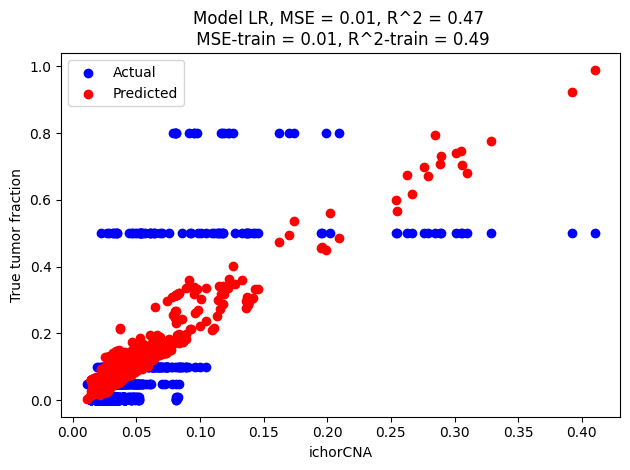

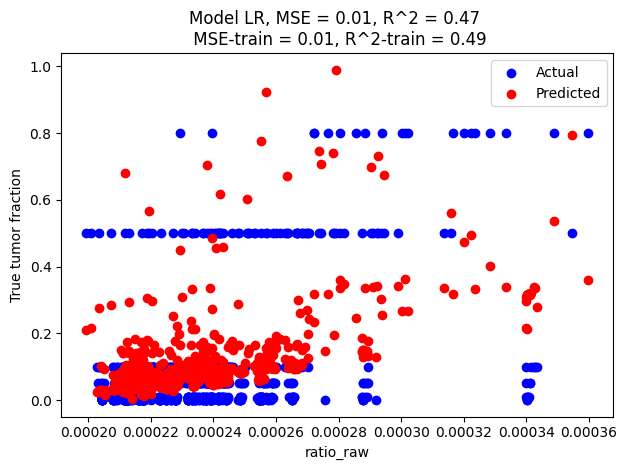

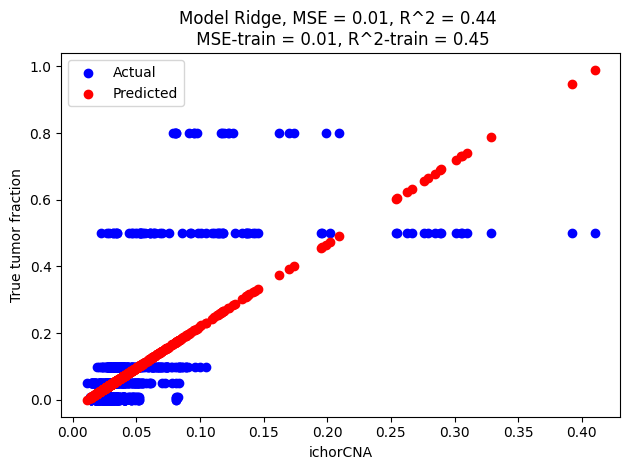

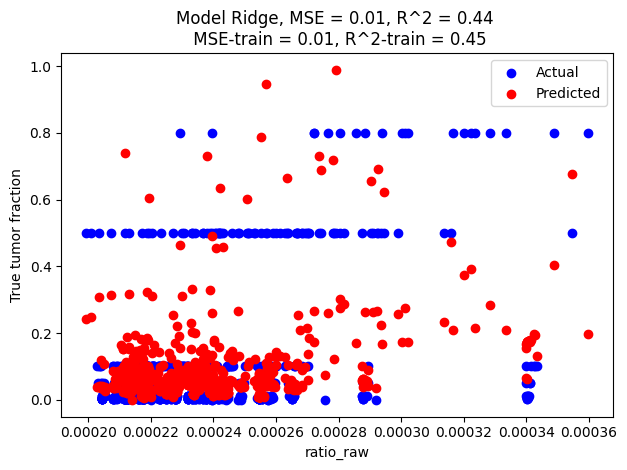

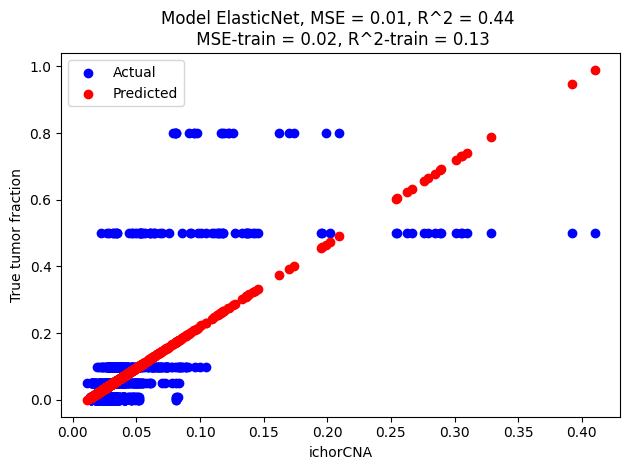

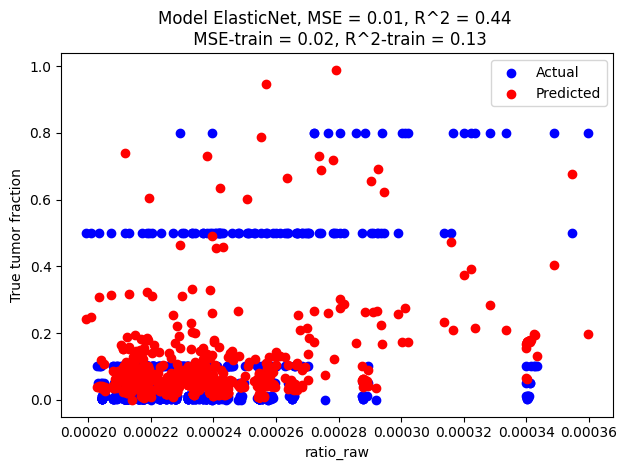

In [12]:
selected_candi_features = "ratio_raw"
#####--------------------------------------------------------#####
##### perform regression with scikit - learn
#####--------------------------------------------------------#####
all_models = dict()

# Perform linear regression using both features: ichorCNA and the selected candi-read feature (raw ratio or in read ratio)
input_features = ["ichorCNA", selected_candi_features] 

# Split the data into training and testing sets
dftrain, dftest = train_test_split(INPUTDF, test_size=0.2, random_state=42)

# Define the features and target variable
X_train = dftrain[input_features]
y_train = dftrain["spike_in_ratio"]
X_test = dftest[input_features]
y_test = dftest["spike_in_ratio"]

# Initialize and train the regression model, fit LR with intercept
model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train)

all_models["LR"] = model
pickle.dump(model, open(os.path.join(path_to_save_models, "LR.pkl"), "wb"))
# Define the models
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()

# Define the parameter grids
ridge_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000], 
                "fit_intercept": [True, False]}
lasso_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000],
                "fit_intercept": [True, False]}

alpha_values = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
l1_ratios = np.linspace(0, 1, 11) 

elasticnet_params = {'alpha': alpha_values, 'l1_ratio': l1_ratios}

# Perform grid search for Ridge
if os.path.isfile(os.path.join(path_to_save_models, "Ridge.pkl")) == False:
    ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
    ridge_grid.fit(X_train, y_train)
    if ridge_grid.best_estimator_.coef_[0] != 0:
        all_models["Ridge"] = ridge_grid
        pickle.dump(ridge_grid, open(os.path.join(path_to_save_models, "Ridge.pkl"), "wb"))
else:
    ridge_grid = pickle.load(open(os.path.join(path_to_save_models, "Ridge.pkl"), "rb"))
    all_models["Ridge"] = ridge_grid
# Perform grid search for Lasso
if os.path.isfile(os.path.join(path_to_save_models, "Lasso.pkl")) == False:
    lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
    lasso_grid.fit(X_train, y_train)
    if lasso_grid.best_estimator_.coef_[0] != 0:
        all_models["Lasso"] = lasso_grid
        pickle.dump(lasso_grid, open(os.path.join(path_to_save_models, "Lasso.pkl"), "wb"))
else:
    lasso_grid = pickle.load(open(os.path.join(path_to_save_models, "Lasso.pkl"), "rb"))
    all_models["Lasso"] = lasso_grid
# Perform grid search for ElasticNet
if os.path.isfile(os.path.join(path_to_save_models, "ElasticNet.pkl")) == False:
    elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2')
    elasticnet_grid.fit(X_train, y_train)
    if elasticnet_grid.best_estimator_.coef_[0] != 0:
        all_models["ElasticNet"] = elasticnet_grid
        pickle.dump(elasticnet_grid, open(os.path.join(path_to_save_models, "ElasticNet.pkl"), "wb"))
else:
    elasticnet_grid = pickle.load(open(os.path.join(path_to_save_models, "ElasticNet.pkl"), "rb"))
    all_models["ElasticNet"] = elasticnet_grid

for i in all_models.keys():
    # Make predictions
    y_pred_train = all_models[i].predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    # Scale the predictions to 0-1 range
    tf_min = y_pred_train.min()
    tf_max = y_pred_train.max()

    y_pred = all_models[i].predict(X_test)
    y_pred_train = (y_pred_train - tf_min)/(tf_max - tf_min)
    y_pred = (y_pred - tf_min) / (tf_max -tf_min)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Plot the results
    for f in input_features:
        plt.scatter(X_test[f], y_test, color='blue', label='Actual')
        plt.scatter(X_test[f], y_pred, color='red', label='Predicted')
        plt.xlabel(f)
        plt.ylabel("True tumor fraction")
        plt.legend()
        plt.title(f"Model {i}, MSE = {mse:.2f}, R^2 = {r2:.2f} \n MSE-train = {mse_train:.2f}, R^2-train = {r2_train:.2f}")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_savefile, f"Regression_{selected_candi_features}_model_{i}_feature_{f}_LODdata.svg"), format='svg')
        plt.show()
    dftrain["predicted_TF"] = [0 if item < 0 else item for item in y_pred_train]
    dftest["predicted_TF"] = [0 if item < 0 else item for item in y_test]
    loddf = pd.concat([dftrain, dftest], axis = 0)
    loddf['spike_in_label'] = pd.Categorical(loddf['spike_in_label'], categories=[input_cancer_class, "Control"])

    fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(loddf['spike_in_label'].apply(lambda x: 1 if x == input_cancer_class else 0), loddf['predicted_TF'])
    num_cancer = loddf[loddf["spike_in_label"] == input_cancer_class].shape[0]
    num_control = loddf[loddf["spike_in_label"] != input_cancer_class].shape[0]

    aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
    aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

    lod_thres = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
    lod_spec = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
    lod_sen = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

    # Calculate the AUC
    roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=loddf, x="spike_in_label", y="predicted_TF", hue="spike_in_label", palette = "Set1")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Class: {input_cancer_class}, threshold: {lod_thres:.2f}, AUC: {roc_auc:.2f}, Sensitivity: {lod_sen:.2f}, Specificity: {lod_spec:.2f}")
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_SPIKE_IN_data.svg"), format='svg')
    plt.show()

    input_features = ["ichorCNA", selected_candi_features] 
    validationdf["predicted_TF"] = all_models[i].predict(validationdf[input_features].to_numpy())
    validationdf.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_Validation_data.xlsx"), index = False)

    input_features = ["ichorCNA", selected_candi_features] 
    loddf_cancer["predicted_TF"] = all_models[i].predict(loddf_cancer[input_features].to_numpy())
    loddf_cancer.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_LOD_data.xlsx"), index = False)

    input_features = ["ichorCNA", selected_candi_features] 
    report4df["predicted_TF"] = all_models[i].predict(report4df[input_features].to_numpy())
    report4df.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_REPORT4_data.xlsx"), index = False)
